# Todo

* done -- Use the time-embedding in front of the RNN
* done -- Do the experiment over several random seeds
    * hidden size = 8, pretrain data is not ignored during FT 
    * hidden size = 16, pretrain data is not ignored during FT
    * hidden size = 32, pretrain data is not ignored during FT
    * hidden size = 8, pretrain data is ignored during FT (num ft epochs = 50)
    * hidden size = 16, pretrain data is ignored during FT (num ft epochs = 50)
    * hidden size = 32, pretrain data is ignored during FT (num ft epochs = 50)
* done -- Plot everything in the same axis
* done -- Use the pytorch RNN cell to get the same result
* done -- Play with the hidden size
* done -- Only finetune on the new data
* done -- Use MAE to compute the test loss
* done -- play with the sampling frequency

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
from collections import namedtuple
from torch.nn import RNN
import json

from copy import deepcopy

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
def generate_sequence(c=0.005, f_0=0, sf=10):
    """
    Generate a linear chirp. x is the time-domain signal and f is the instantaneous frequency
    """
    t = np.arange(0, 50, 1/sf)
    f = c * t + f_0
    phi = 2 * np.pi * (c / 2 * t**2 + f_0 * t)
    x = np.sin(phi)
    return x, f, t

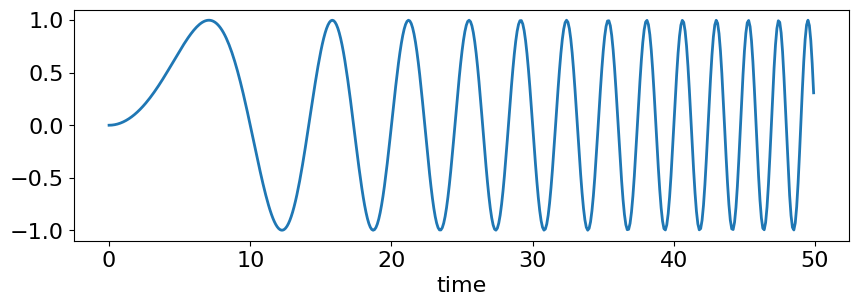

In [10]:
X, F, T = generate_sequence(c=0.01, f_0=0, sf=10)
fontsize = 16
lw = 2
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(T, X, label='Original Signal', lw=lw)
ax.set_xlabel('time', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
plt.show()

In [12]:
class TimeEmbedding(nn.Module):
    """form the Fourier time-embedding"""
    def __init__(self, tdim=50):
        super(TimeEmbedding, self).__init__()
        self.freqs = 2 * np.pi * torch.linspace(0, 0.5, tdim // 2).unsqueeze(0)

    def forward(self, t):
        # t = t.unsqueeze(-1)
        sin_emb = torch.sin(self.freqs.to(t.device) * t)
        cos_emb = torch.cos(self.freqs.to(t.device) * t)
        return torch.cat([sin_emb, cos_emb], dim=-1)

class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, tdim=50, embed_time=False):
        super(RNNCell, self).__init__()
        self.hidden_size = hidden_size
        self.embed_time = embed_time

        if embed_time:
            self.time_embedding = TimeEmbedding(tdim=tdim)
            input_size = tdim

        # self.rnn = RNN(input_size, hidden_size, batch_first=True)
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        # self.rnn = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if self.embed_time:
            x = self.time_embedding(x)
        h, _ = self.rnn(x)
        output = self.h2o(h)
        return output

In [13]:
class Experiment:
    def __init__(self, data, t_pretrain, hp_pretrain, hp_finetune, ignore_pretrained_data=False, sample_rate=10):
        self.data = data
        self.t_pretrain = int(t_pretrain * sample_rate)
        self.hp_pretrain = hp_pretrain
        self.hp_finetune = hp_finetune
        self.ignore_pretrained_data = ignore_pretrained_data
        self.sample_rate = sample_rate

        self.pretrained_state_dict = None

    def train_rnn(self, rnn, t, finetune=False):
        X, Y = self.data
        hp = self.hp_finetune if finetune else self.hp_pretrain
        t_pretrain = self.t_pretrain

        # train the RNN on the first t steps of the sequence
        input_seq, output_seq = X[:t], Y[:t]
        len_seq = len(input_seq)

        x = torch.from_numpy(input_seq).view(1, -1, 1).float()
        y = torch.from_numpy(output_seq).float()

        rnn.train()
        optimizer = torch.optim.Adam(rnn.parameters(), lr=hp.lr)

        criterion = nn.MSELoss(reduction='none')
        pbar = tqdm(range(hp.num_epochs))

        for epoch in pbar:    
            # iterate over the sequence
            out = rnn(x)
            
            # compute loss
            unmasked_losses = criterion(out.squeeze(), y)
            if finetune:
                if self.ignore_pretrained_data:
                    mask = torch.zeros_like(unmasked_losses, dtype=torch.bool)
                    mask[t_pretrain:] = True
                    masked_losses = unmasked_losses * mask.float()
                    loss = masked_losses.mean()
                else:
                    loss = unmasked_losses.mean()
            else:
                loss = unmasked_losses.mean()

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_description(f"Epoch {epoch+1}/{hp.num_epochs}, Loss: {loss.item()/len_seq:.4f}")
        return rnn

    def evaluate(self, rnn, t):
        # get data (only evaluate on the future, beyond t)
        X, Y = self.data
        input_seq, output_seq = X, Y

        x = torch.from_numpy(input_seq).view(1, -1, 1).float()
        y = torch.from_numpy(output_seq).float()

        rnn.eval()
        with torch.no_grad():
            out = rnn(x)
            unmasked_losses = (out.squeeze() - y).abs().detach().numpy()
        return np.mean(unmasked_losses[t:])
    
    def pretrain(self, rnn):
        """
        pretrain the RNN on the first t steps of the sequence
        """
        rnn = self.train_rnn(rnn, self.t_pretrain, finetune=False)
        error = self.evaluate(rnn, self.t_pretrain)
        self.pretrained_state_dict = deepcopy(rnn.state_dict())
        return rnn.state_dict(), error

    def run(self, rnn, t, finetune=True):
        """
        We train an RNN to predict the signal in the future

        The RNN pretrained on the first `t_pretrain` steps of the sequence.

        When train == True: 
            The RNN is trained on the first t (including the pretraining data) steps of the sequence and evaluated on the future steps

        When train == False
            The RNN is not trained at all (no gradient steps)    
        """
        t = int(t * self.sample_rate)

        if self.pretrained_state_dict is not None:
            rnn.load_state_dict(self.pretrained_state_dict)
        else:
            raise ValueError("Pretrained state dict is None. Please call pretrain() first.")

        # finetune
        if finetune:
            rnn = self.train_rnn(rnn, t, finetune=True)

        # evaluate
        error = self.evaluate(rnn, t)
        
        return rnn.state_dict(), error
    

def get_output(rnn, state_dict, inputs):
    rnn.load_state_dict(state_dict)
    rnn.eval()
    torch_inputs = torch.from_numpy(inputs).view(1, -1, 1).float()
    with torch.no_grad():
        out = rnn(torch_inputs)
    return out

In [89]:
hidden_size = 32
tdim = 50
ignore_pretrained_data = True
t_pretrain = 25
t_list = np.arange(25+1, 40, 1)
sample_rate = 10

Hyperparameters = namedtuple('Hyperparameters', ['lr', 'num_epochs'])
hp_pretrain = Hyperparameters(
    lr=0.001, 
    num_epochs=1000
)
hp_finetune = Hyperparameters(
    lr=0.001, 
    num_epochs=100
)

In [90]:
X, F, T = generate_sequence(c=0.01, sf=sample_rate)
inputs = T
outputs = X

In [91]:
exp = Experiment(
    data=(inputs, outputs),
    t_pretrain=t_pretrain,
    hp_pretrain=hp_pretrain,
    hp_finetune=hp_finetune,
    ignore_pretrained_data=ignore_pretrained_data,
    sample_rate=sample_rate
)

In [92]:
set_seed(1996)
rnn = RNNCell(
    input_size=1,
    hidden_size=hidden_size,
    output_size=1,
)
# rnn = RNNCell(
#     input_size=1,
#     hidden_size=hidden_size,
#     output_size=1,
#     tdim=tdim,
#     embed_time=True
# )

pt_state_dict, initial_error = exp.pretrain(deepcopy(rnn))

err_ft = []
err_noft = []
ft_models = []
noft_models = []
for t in t_list:
    ft_model, error_ft = exp.run(deepcopy(rnn), t, finetune=True)
    noft_model, error_noft = exp.run(deepcopy(rnn), t, finetune=False)
    ft_models.append(ft_model)
    noft_models.append(noft_model)
    err_ft.append(error_ft)
    err_noft.append(error_noft)

Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 23.18it/s]


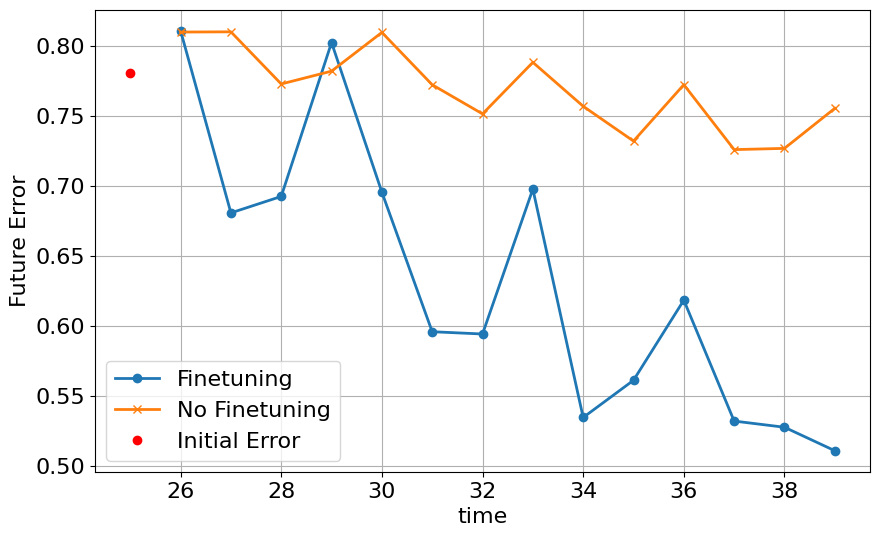

In [93]:
fig, ax = plt.subplots(figsize=(10, 6))
fontsize = 16
lw = 2
ax.plot(t_list, err_ft, label='Finetuning', marker='o', lw=lw)
ax.plot(t_list, err_noft, label='No Finetuning', marker='x', lw=lw)
ax.plot([t_pretrain], [initial_error], 'ro', label='Initial Error')
ax.set_xlabel('time', fontsize=fontsize)
ax.set_ylabel('Future Error', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(fontsize=fontsize)
ax.grid(True)
plt.show()

In [94]:
t = 30
idx = t_list.tolist().index(t)
out_ft = get_output(rnn, ft_models[idx], inputs)
out_noft = get_output(rnn, noft_models[idx], inputs)

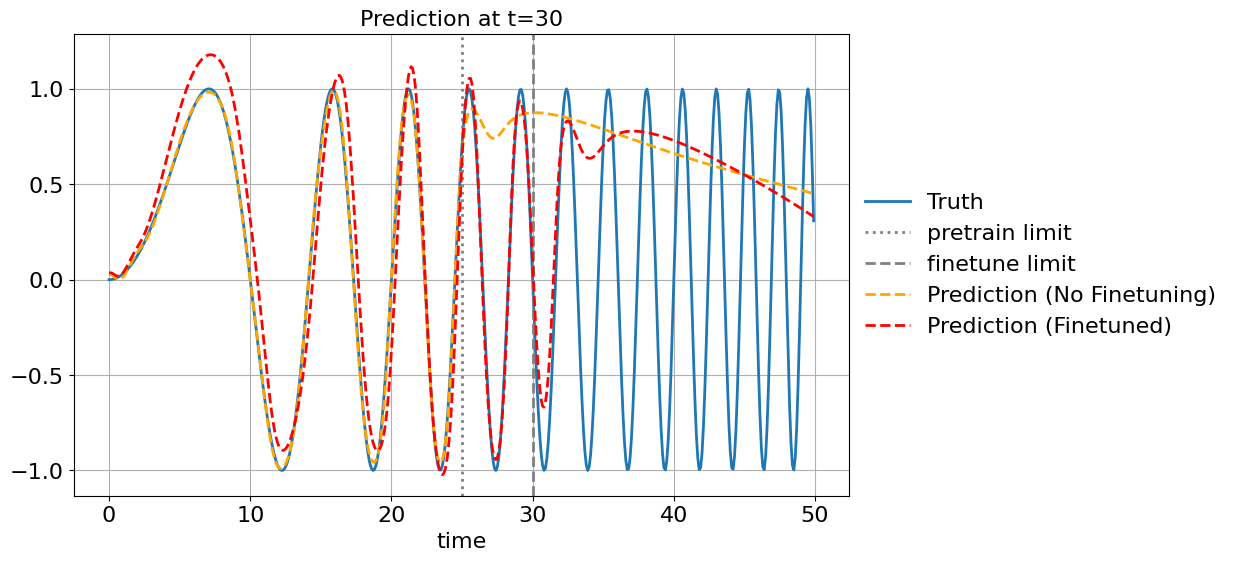

In [95]:
fig, ax = plt.subplots(figsize=(10, 6))
fontsize = 16
lw = 2
ax.plot(T, outputs, label='Truth', lw=lw)
ax.axvline(x=t_pretrain, color='gray', linestyle=':', label='pretrain limit', lw=lw)
ax.axvline(x=t, color='gray', linestyle='--', label='finetune limit', lw=lw)
ax.plot(T, out_noft.squeeze().numpy(), label='Prediction (No Finetuning)', linestyle='--', color='orange', lw=lw)
ax.plot(T, out_ft.squeeze().numpy(), label='Prediction (Finetuned)', linestyle='--', color='red', lw=lw)
ax.set_title(f'Prediction at t={t}', fontsize=fontsize)
ax.set_xlabel('time', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(fontsize=fontsize, loc='upper right', bbox_to_anchor=(1.5, 0.7), frameon=False)
ax.grid(True)
plt.show()
